# This Notebook presents an expriment of Theory Of Mind on Schelling Coordination Game

In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Plots, Memoization


We have 2 players: Bob and Alice.
They Want to arrive to the same point. they can't communicate, they only can infernce about each other.
We will model it using PPL. And use Practicle Gibbs Sampling.

In [52]:
function get_random_sample(samples)
    return Random.rand(samples)
end

get_random_sample (generic function with 1 method)

This function compute samples if not already computed.<br>
And takes a random sample if the samples already memoized

In [124]:
function my_memoized_sample(memo, model, sampler, iterations, depth)
    if !haskey(memo, depth)
        samples = sample(model, sampler, iterations)
        memo[depth] = samples[:my_location]
    end
    return get_random_sample(memo[depth])
end

my_memoized_sample (generic function with 1 method)

In [54]:
@model function bob(depth = 0, popularity=0.55)
    my_location ~ Bernoulli(popularity)
    return round(Int64, my_location)
end

bob (generic function with 3 methods)

In [125]:
@model function alice(other_person_place, popularity = 0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    other_location = my_memoized_sample(memo, other_person_place(), IS(), 10000, depth)
    other_location ~ Dirac(my_location)
    return round(Int64, my_location)
end

alice (generic function with 3 methods)

In [126]:
memo = Dict{Int64, Array{Int64}}()
samples = sample(alice(bob, 0.55, 10), IS(), 10000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×3×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = my_location, other_location
internals         = lp

Summary Statistics
      parameters      mean       std   naive_se      mcse         ess      rha ⋯
          Symbol   Float64   Float64    Float64   Float64     Float64   Float6 ⋯

     my_location    0.5557    0.4969     0.0050    0.0055   9208.6521    1.000 ⋯
  other_location    0.5557    0.4969     0.0050    0.0055   9208.6521    1.000 ⋯
                                                                1 column omitted

Quantiles
      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

     my_location    0.0000    0.0000    1.0000    1.0000    1.0000
  other_location    0.0000    0.0000    1.0000    1.0000    1.0000


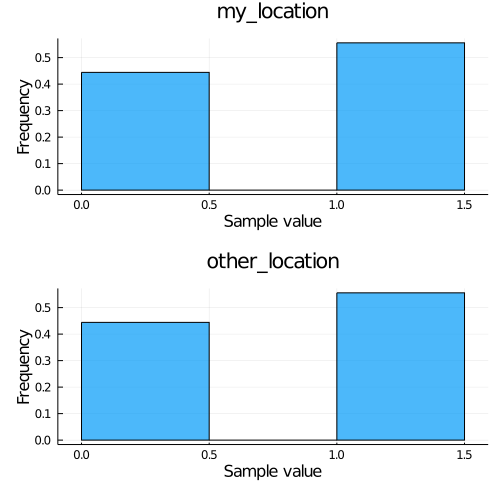

In [127]:
histogram(samples, bins = 2, normalize=:probability)

In [128]:
@model function alice_2(other_person_place, popularity = 0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    other_location = my_memoized_sample(bob_memo, other_person_place(alice_2, popularity, depth - 1), IS(), 10000, depth)
    other_location ~ Dirac(my_location)
    return my_location
end

alice_2 (generic function with 3 methods)

In [129]:
@model function bob_2(other_person_place, popularity=0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    if depth == 0
       return my_location 
    else
        other_location = my_memoized_sample(alice_memo, other_person_place(bob_2, popularity, depth), IS(), 10000, depth)
        other_location ~ Dirac(my_location)
        return my_location
    end
end

bob_2 (generic function with 3 methods)

In [130]:
@time begin
    bob_memo , alice_memo = Dict{Int64, Array{Int64}}(), Dict{Int64, Array{Int64}}()
    result = sample(alice_2(bob_2, 0.55, 20), IS(), 10000)
end

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 

 30.818302 seconds (125.21 M allocations: 7.449 GiB, 10.84% gc time)


Chains MCMC chain (10000×3×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = my_location, other_location
internals         = lp

Summary Statistics
      parameters      mean       std   naive_se      mcse         ess      rha ⋯
          Symbol   Float64   Float64    Float64   Float64     Float64   Float6 ⋯

     my_location    0.5421    0.4982     0.0050    0.0047   9899.5288    1.000 ⋯
  other_location    0.5421    0.4982     0.0050    0.0047   9899.5288    1.000 ⋯
                                                                1 column omitted

Quantiles
      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

     my_location    0.0000    0.0000    1.0000    1.0000    1.0000
  other_location    0.0000    0.0000    1.0000    1.0000    1.0000


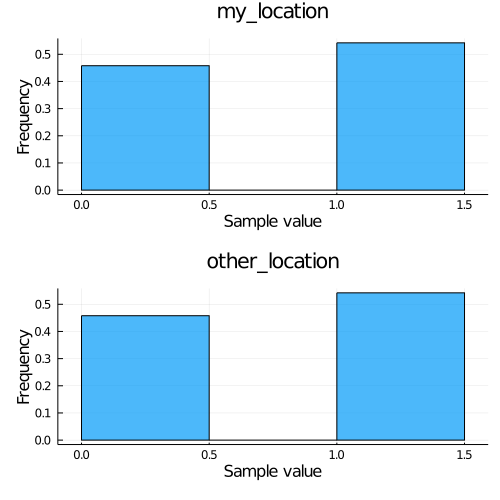

In [131]:
histogram(result, bins = 2, normalize=:probability)